In [7]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [12]:
%matplotlib inline
from __future__ import division
import matplotlib
import numpy as np
from pylab import *
import os
import subprocess
DEVNULL = open(os.devnull, 'wb')
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4)})
plotStyles={"markersize":20,"markeredgewidth":3.0,"linewidth":3.0}
stepStyles={"markersize":20,"markeredgewidth":3.0,"linewidth":3.0,"where":"post"}
np.seterr(divide='ignore',invalid='ignore')
pass

# Setup the notebook.

In [74]:
import h5py
import math
testParams={
    "dimerization_marked_1":[150,150,0.1,9.9],
    "dimerization_marked_2":[1500,1500,0.01,9.99],
    "dimerization_marked_3":[15000,15000,0.001,9.999],
}
testNames=testParams.keys()
def isclose(a, b, rel_tol=1e-09, abs_tol=0.0):
    return abs(a-b) <= max(rel_tol * max(abs(a), abs(b)), abs_tol)

speciesNames=[
    "A(dimer,M~N)",
    "A(dimer!1,M~N).A(dimer!1,M~N)",
    "A(dimer!1,M~N).A(dimer!1,M~Y)",
    "A(dimer,M~Y)",
    "A(dimer!1,M~Y).A(dimer!1,M~Y)",
]

# Execute the tests.

In [75]:
%%bash
rm -rf tmp && mkdir tmp

In [76]:
bnglFilename="dimerization_marked.bngl"

for testName in testNames:
    outputFilename = "tmp/%s.lm"%(testName)
    if os.path.isfile(outputFilename): os.remove(outputFilename)
    with open("%s.bngl.log"%(outputFilename), "w") as logfile:
        if (subprocess.call(["lm_bionetgen_import",outputFilename,bnglFilename,"--verbose","A0_Y=%0.3e"%(testParams[testName][0]),"A0_N=%0.3e"%(testParams[testName][1]),"k1=%0.3e"%(testParams[testName][2]),"k2=%0.3e"%(testParams[testName][3])], stdout=logfile, stderr=logfile) != 0): print "Error: lm_bionetgen_import failed for %s"%(outputFilename)
    if (subprocess.call(["lm_setp",outputFilename,"writeInterval=1e-3","maxTime=1e0"], stdout=DEVNULL, stderr=DEVNULL) != 0): print "Error: lm_setp failed for %s"%(outputFilename)        
    with open("%s.simulate.log"%(outputFilename), "w") as logfile:
        if (subprocess.call(["lmes","-f",outputFilename,"-r","1-1000","-sl","lm::cme::GillespieDSolver"], stdout=logfile, stderr=logfile) != 0): print "Error: lmes failed for %s"%(outputFilename)
print "Finished."

Finished.


# Spot check some simulations.

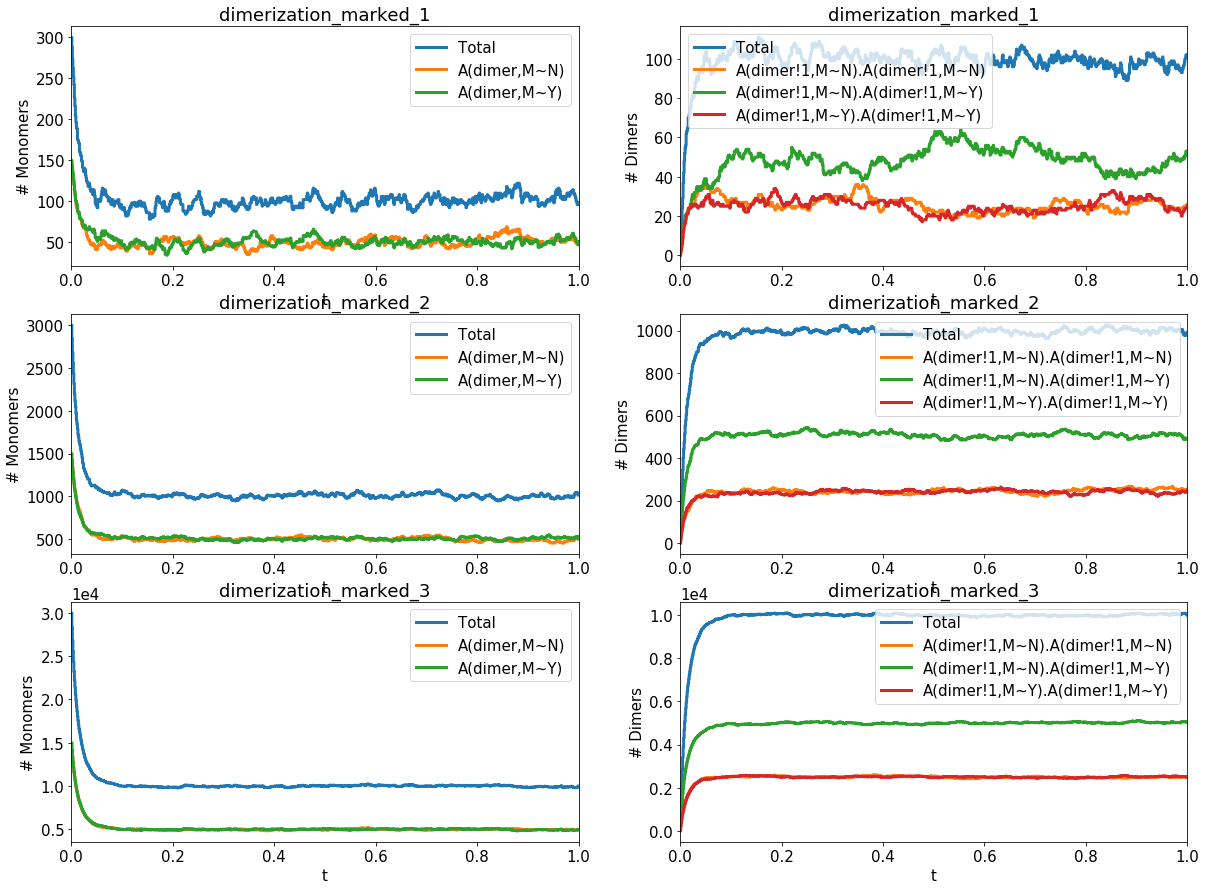

In [77]:
# Plot the time series for a single replicate.
for i,testName in enumerate(testNames):
    testOutputFilename="tmp/%s.lm"%(testName)
    fp = h5py.File(testOutputFilename, "r")
    matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (20,5*len(testNames))})
    for replicate in (1,):
        counts=np.array(fp["/Simulations/%07d/SpeciesCounts"%replicate], dtype=double)
        times=np.array(fp["/Simulations/%07d/SpeciesCountTimes"%replicate], dtype=double)
        plt.subplot(len(testNames),2,i*2+1)
        step(times,counts[:,0]+counts[:,3], label="Total", **stepStyles)
        step(times,counts[:,0], label="%s"%speciesNames[0], **stepStyles)
        step(times,counts[:,3], label="%s"%speciesNames[3], **stepStyles)
        xlabel('t'); xlim([0,1e0]); ylabel('# Monomers'); title(testName); legend()
        plt.subplot(len(testNames),2,i*2+2)
        step(times,counts[:,1]+counts[:,2]+counts[:,4], label="Total", **stepStyles)
        step(times,counts[:,1], label="%s"%speciesNames[1], **stepStyles)
        step(times,counts[:,2], label="%s"%speciesNames[2], **stepStyles)
        step(times,counts[:,4], label="%s"%speciesNames[4], **stepStyles)
        xlabel('t'); xlim([0,1e0]); ylabel('# Dimers'); title(testName); legend()
    fp.close()
pass

### Define the tests.

In [78]:
def test_dimerization_marked_1(testOutputFilename):
    test_dimerization_marked(testOutputFilename, 100.0, 1e-2)
def test_dimerization_marked_2(testOutputFilename):
    test_dimerization_marked(testOutputFilename, 1000.0, 1e-2)
def test_dimerization_marked_3(testOutputFilename):
    test_dimerization_marked(testOutputFilename, 10000.0, 1e-2)
    
def test_dimerization_marked(testOutputFilename, exceptedValue, allowedDeviation):
    fp = h5py.File(testOutputFilename, "r")
    replicates=fp["/Simulations"].keys()
    k=0
    mSim=None
    vSim=None
    times=None
    for replicate in replicates:
        if times is None:
            times = np.array(fp["/Simulations/%s/SpeciesCountTimes"%replicate], dtype=double)
        splitcounts = np.array(fp["/Simulations/%s/SpeciesCounts"%replicate], dtype=double)
        counts = np.zeros((splitcounts.shape[0],2))
        counts[:,0] = splitcounts[:,0]+splitcounts[:,3]
        counts[:,1] = splitcounts[:,1]+splitcounts[:,2]+splitcounts[:,4]
        if mSim is None:
            k += 1
            mSim = counts
            vSim = np.zeros(counts.shape, dtype=double)
        else:
            k += 1
            mSim = mSim + (counts-mSim)/k
            vSim = vSim + (counts-mSim)*(counts-mSim)
    vSim /= float((k-1))
    value = np.mean(mSim[-100:-1,0])

    plt.subplot(len(testNames),2,i*2+1)
    plt.plot(times,mSim[:,0], **plotStyles)
    plt.plot(times,mSim[:,1], **plotStyles)
    yscale('linear'); xlabel('t'); ylabel('E{X(t)}'); title("%s, $\mu$=%0.2f"%(testName,value))
    plt.subplot(len(testNames),2,i*2+2)
    plt.plot(times,vSim[:,0], **plotStyles)
    plt.plot(times,vSim[:,1], **plotStyles)
    yscale('log'); xlabel('t'); ylabel('Var{X(t)}')
    fp.close()

    if not isclose(value,exceptedValue,allowedDeviation): raise Exception("incorrect value",value)

### Run the tests.

[dimerization_marked_1]                                      : passed.


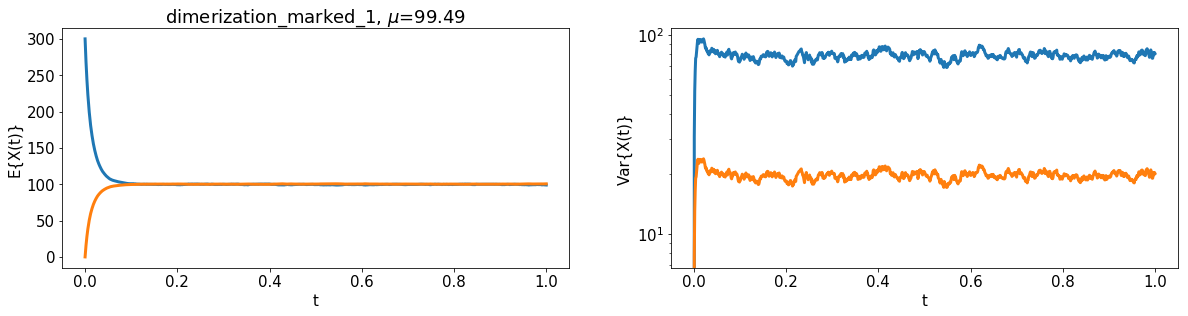

[dimerization_marked_2]                                      : passed.


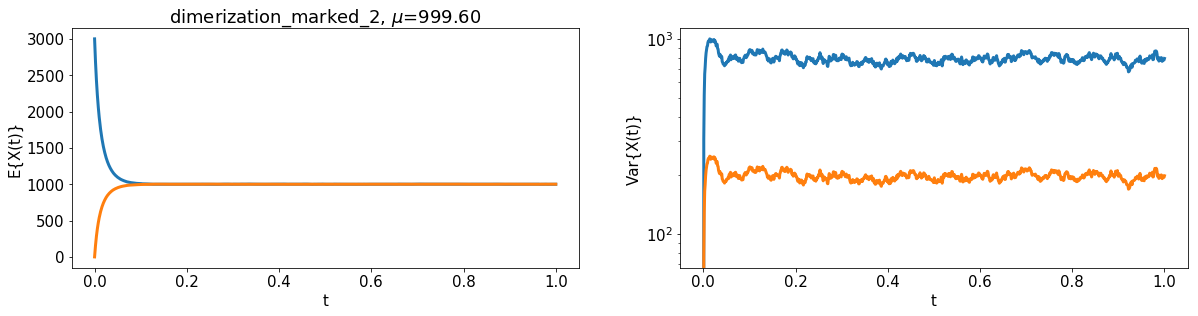

[dimerization_marked_3]                                      : passed.


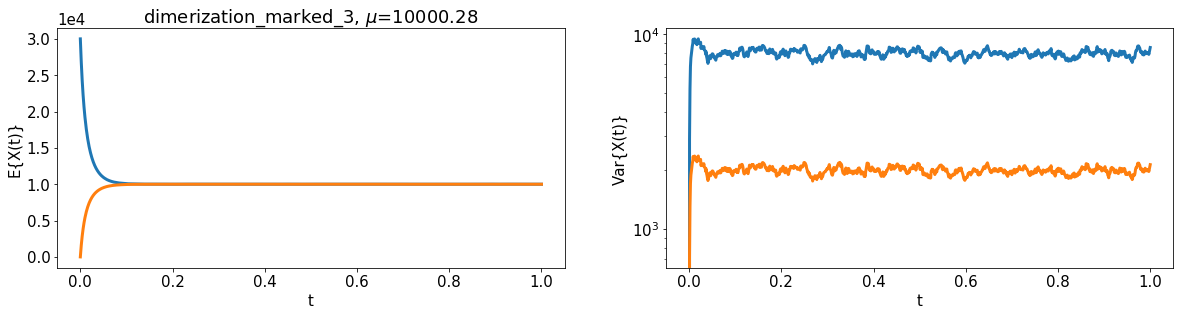

In [79]:
testMethods = {
    "dimerization_marked_1": test_dimerization_marked_1,
    "dimerization_marked_2": test_dimerization_marked_2,
    "dimerization_marked_3": test_dimerization_marked_3,
}
matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (20,5*len(testNames))})
for i,testName in enumerate(testNames):
    try:
        testOutputFilename="tmp/%s.lm"%(testName)
        testMethods[testName](testOutputFilename)
    except Exception as e:
        print "%-60s : FAILED with:"%("["+testName+"]"),e
    except:
        print "%-60s : FAILED with: Unknown exception"%("["+testName+"]")
    else:
        print "%-60s : passed."%("["+testName+"]")
    plt.show()
pass

In [80]:
%%bash
rm -rf tmp